<a href="https://colab.research.google.com/github/Mkreitman/Fellowship.ai_Challenge/blob/main/fellowshipCVflowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, ImageCollection
import cv2
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import fastai
from fastai.vision import *
from fastai.vision.all import *
import albumentations as alb
from albumentations import ShiftScaleRotate
from albumentations.pytorch import ToTensorV2
from PIL import Image
import seaborn as sns
import collections
from ipywidgets import FileUpload
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import datetime
from google.colab import drive

In [3]:
drive. mount('/content/drive')

Mounted at /content/drive


## Running Google Colab GPU

In [4]:
print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)


In [5]:
import torch
torch.cuda.is_available()

True



## Loading and Exploration

In [6]:
# Create the ImageCollection object
skimage_collection = ImageCollection('/content/drive/MyDrive/Fellowship.ai/flower_images/*.jpg', load_func=imread, conserve_memory=False, plugin='matplotlib')

# Print the number of images loaded
print(f"Number of images loaded: {len(skimage_collection)}")

Number of images loaded: 8189


In [7]:
#loading csv made on my local machine by using Matlab file containing integer labels and the list
#of flower names from the category statistics page
#https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html
df = pd.read_csv('/content/drive/MyDrive/Fellowship.ai/flower_data.csv')

In [8]:
df.head()

,flower_id,label_id,class
0,1,77,passion flower
1,2,77,passion flower
2,3,77,passion flower
3,4,77,passion flower
4,5,77,passion flower


In [9]:
print(str(df['class'].value_counts().sum())+" total flower images.")
print(str(len(df['class'].unique()))+" flower classes.")
df['class'].value_counts()

8189 total flower images.
102 flower classes.


petunia                     258
passion flower              251
wallflower                  196
water lily                  194
watercress                  184
                           ... 
moon orchid                  40
bolero deep blue             40
mexican aster                40
pink primrose                40
prince of wales feathers     40
Name: class, Length: 102, dtype: int64

In [10]:
#turning series into a list in preparation for training on the data.
label_list = df['class'].to_list()

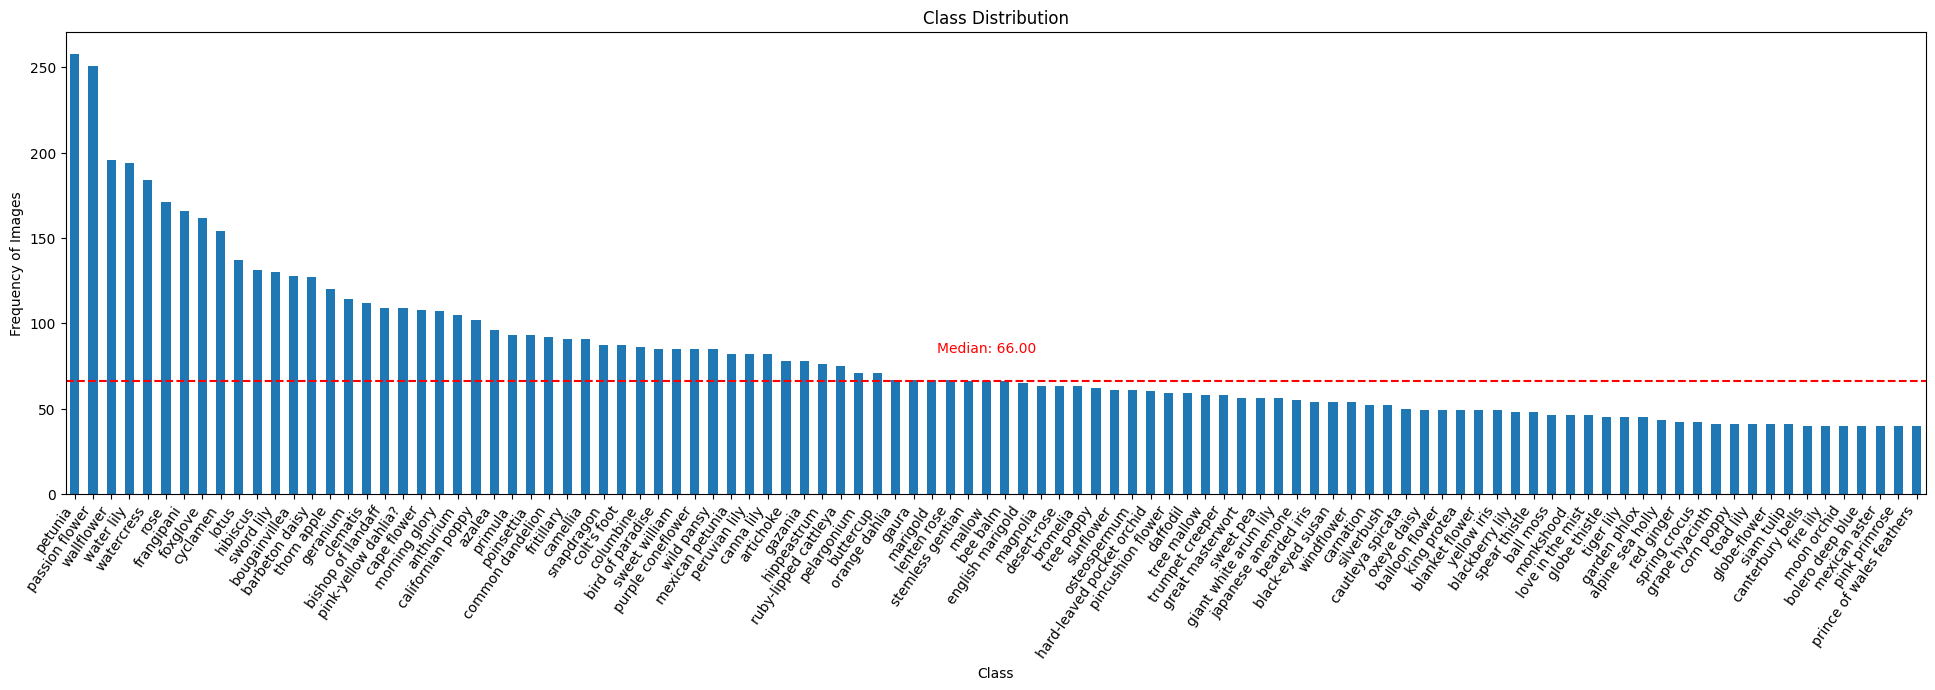

In [11]:
median_value = np.median(df['class'].value_counts())
#visualizing the distribution over all classes
class_counts = df['class'].value_counts()
plt.figure(figsize=(24, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency of Images')
plt.title('Class Distribution')
plt.axhline(y=median_value, color='red', linestyle='--', label='Average Frequency')
plt.text(50, median_value + 15, f'Median: {median_value:.2f}', color='red', ha='center', va='bottom')
plt.xticks(rotation=55, ha='right')
plt.show()

##### Class imbalance seems to be an issue here.  I plan to use weighted loss during dataloader step.

In [12]:
# Calculating class weights
total_samples = df['class'].value_counts().sum()
class_weights = [total_samples / (len(df['class'].unique()) * df['class'].value_counts()[class_i]) for class_i in df['class']]

total_weight = sum(class_weights)
#normalizing class weights
class_weights_normalized = [weight / total_weight for weight in class_weights]

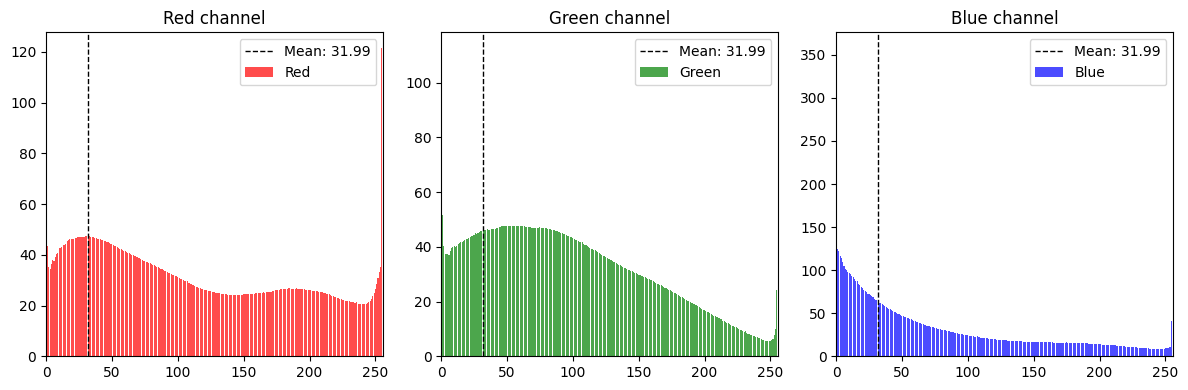

In [13]:
# Initializing arrays to hold all pixel histograms of each channel
hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

# Iterate through each image in the collection
for img in skimage_collection:

    # Split the image into its respective channels
    r, g, b = cv2.split(img)

    # Compute histogram for each channel and accumulate
    hist_r += np.histogram(r, bins=256, range=[0,256], density=True)[0]
    hist_g += np.histogram(g, bins=256, range=[0,256], density=True)[0]
    hist_b += np.histogram(b, bins=256, range=[0,256], density=True)[0]

#Median & mean calculations
mean_r = np.mean(hist_r)
mean_g = np.mean(hist_g)
mean_b = np.mean(hist_b)

# Prepare bins for histogram
bins = np.arange(256)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram for Red channel
axs[0].bar(bins, hist_r, color='red', alpha=0.7, label='Red')
axs[0].set_title('Red channel')
axs[0].set_xlim([0,256])
axs[0].axvline(mean_r, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_r:.2f}')
axs[0].legend()

# Plot histogram for Green channel
axs[1].bar(bins, hist_g, color='green', alpha=0.7, label='Green')
axs[1].set_title('Green channel')
axs[1].set_xlim([0,256])
axs[1].axvline(mean_g, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_g:.2f}')
axs[1].legend()

# Plot histogram for Blue channel
axs[2].bar(bins, hist_b, color='blue', alpha=0.7, label='Blue')
axs[2].set_title('Blue channel')
axs[2].set_xlim([0,256])
axs[2].axvline(mean_b, color='k', linestyle='dashed', linewidth=1, label=f'Mean: {mean_b:.2f}')
axs[2].legend()

# Add legend
for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()

### Both red and green channel have right-skew shape.

### Now I want to visualize the distribution of image dimensions in my data.

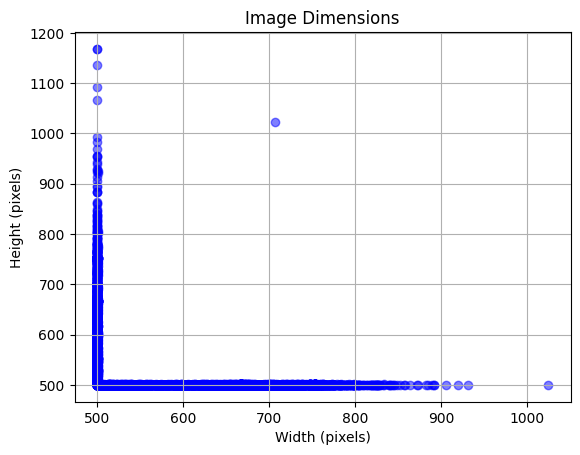

In [15]:
#creating a list of tuples that hold the shape (width and height) of each image
image_dimensions = [(image.shape[1], image.shape[0]) for image in skimage_collection]
#unzipping image_dimensions
widths, heights = zip(*image_dimensions)
#building a scatter plot
plt.scatter(widths, heights, marker='o', color='blue', alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

### While there are a few outliers, the rest seem to be reasonably similar in size.

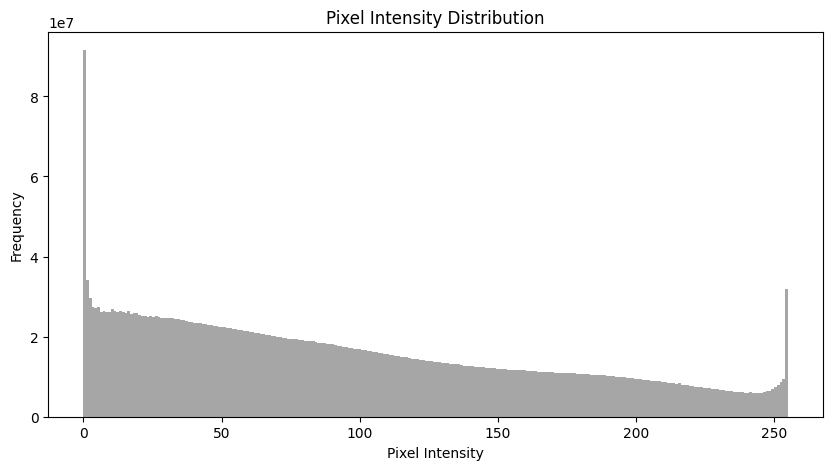

In [16]:
#exploring pixel intensity on the first half the images

# Specify the path to the directory containing your images
images_directory = "/content/drive/MyDrive/Fellowship.ai/flower_images/"
all_image_paths = glob.glob(images_directory + "*.jpg")

split_index = len(skimage_collection) // 2

# Subset the first half of the images
subset_paths = all_image_paths[:split_index]
skimage_subset = ImageCollection(subset_paths)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

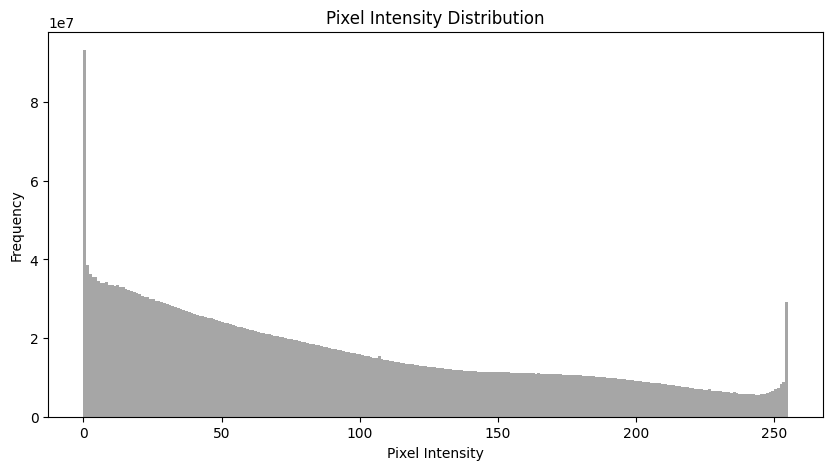

In [17]:
#exploring pixel intensity on second half the images

# Subset the second half of the images
subset_paths_second_half = all_image_paths[split_index:]
skimage_subset = ImageCollection(subset_paths_second_half)

pixel_values = [img.flatten() for img in skimage_subset]

plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(pixel_values), bins=256, color='gray', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

### Both graphs show a negative linear relationship and no aparent peak. There are outlier spikes at left and righthand sides.

In [18]:
#loading image files into folder called images
images = get_image_files("/content/drive/MyDrive/Fellowship.ai/flower_images/")


In [19]:
def first_three(image_list):
    resized_images = []
    for path in image_list[:3]:
        img = Image.open(path)
        resized_img = img.resize((img.width // 4, img.height // 4))
        resized_images.append(resized_img)
    return display(resized_images[0]), display(resized_images[1]), display(resized_images[2])

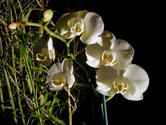

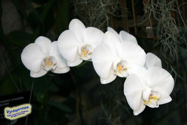

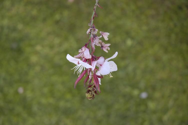

(None, None, None)

In [20]:
first_three(images)


Problem!  This flower is not the passion flower from img_00001.jpg.  The get_images_files sorting method is messing up the order of flowers.

In [21]:
# Sorting images based on filename sequence in dataset
def custom_sort(file_path):
    # Extract numeric part from the file name (assuming it ends with a number)
    return int(''.join(filter(str.isdigit, file_path.stem)))

# Sort the images based on the custom sorting function
images = sorted(images, key=custom_sort)

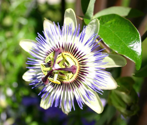

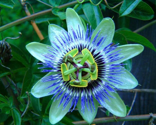

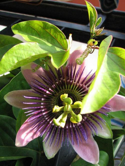

(None, None, None)

In [22]:
first_three(images)

#### Fixed!  The first three pictures are a passion flowers (image_00001.jpg, image_00002.jpg, image_00003.jpg).

In [23]:
train_images, test_images = train_test_split(images, test_size=0.1, random_state=25)
train_label_list, test_label_list = train_test_split(label_list, test_size=0.1, random_state=25)


## Modeling

#### Building baseline model with normalization and class_weights to help with imbalanced classes.

In [24]:
#Create ImageDataLoader
dl_base = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(128),
       batch_tfms=[Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights,
       bs = 32)

In [37]:
#create model
learn_base = vision_learner(dl_base, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0020892962347716093)

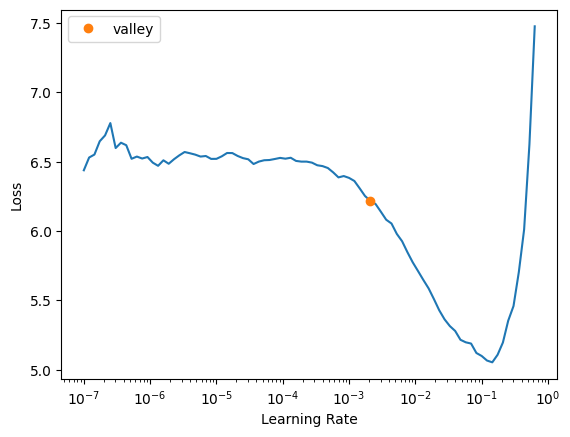

In [38]:
#finding optimal learning rate
learn_base.lr_find()

In [39]:
learn_base.fit_one_cycle(8, lr_max= 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.613019,1.058949,0.268657,00:19
1,1.149196,0.554344,0.154681,00:19
2,0.676708,0.423182,0.113976,00:19
3,0.431874,0.349988,0.093623,00:19
4,0.305772,0.296398,0.080054,00:19
5,0.213410,0.225343,0.060380,00:19
6,0.124406,0.204681,0.059023,00:19
7,0.100020,0.209491,0.057666,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.222008,0.303931,0.082090,00:19


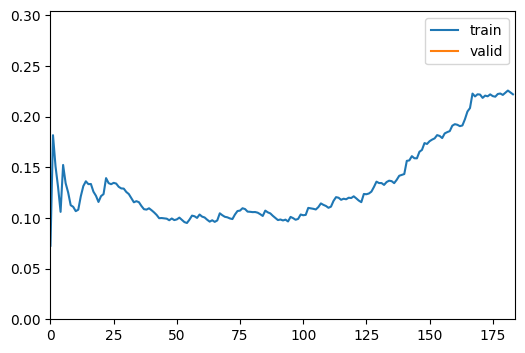

epoch,train_loss,valid_loss,error_rate,time
0,0.141919,0.212171,0.057666,00:21
1,0.143927,0.345546,0.075305,00:21
2,0.152934,0.236067,0.059701,00:21
3,0.107673,0.218782,0.056988,00:21
4,0.071957,0.176630,0.046811,00:21
5,0.059989,0.153567,0.041384,00:21
6,0.035680,0.175247,0.042062,00:21
7,0.029500,0.167064,0.040706,00:21


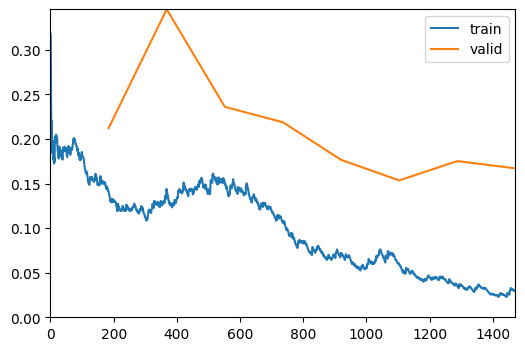

In [40]:
#tuning hyperparameters
learn_base.fine_tune(8, 3e-3, cbs=ShowGraphCallback())

In [41]:
learn_base.summary()

Sequential (Input shape: 32 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 64 x 64   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 32 x 32   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 32 x 32  
Conv2d                                    16384      True      
BatchNorm2d                        

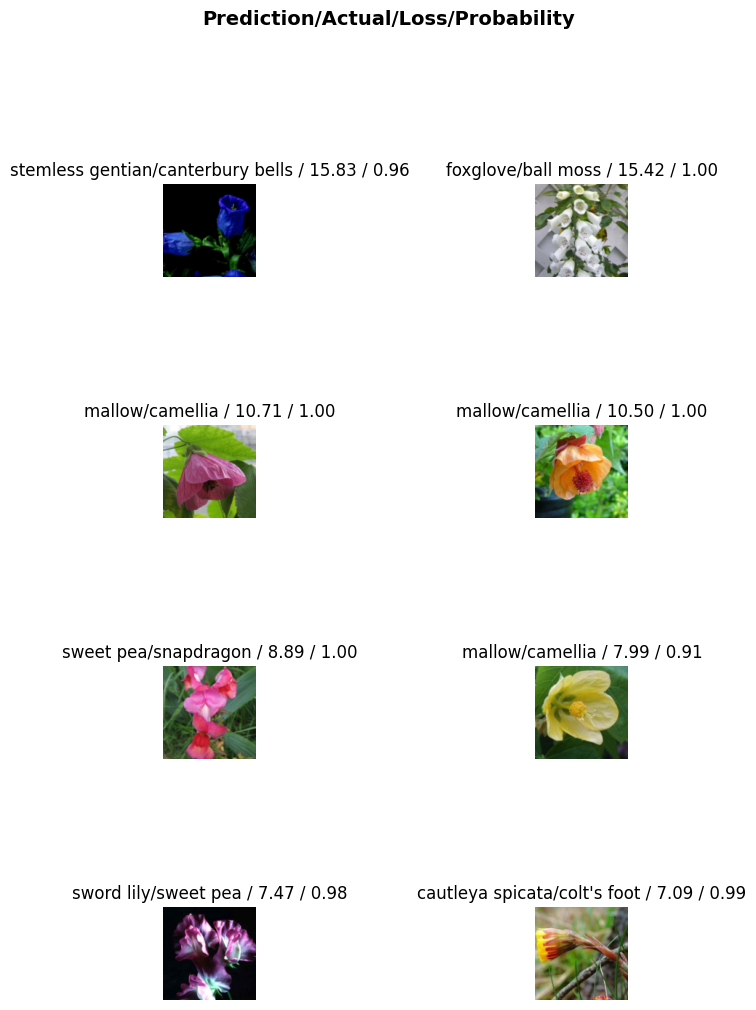

[('camellia', 'mallow', 5),
 ('common dandelion', 'sunflower', 2),
 ('english marigold', 'barbeton daisy', 2),
 ('lenten rose', 'clematis', 2),
 ('peruvian lily', 'clematis', 2),
 ('snapdragon', 'sweet pea', 2),
 ('snapdragon', 'sword lily', 2),
 ('anthurium', 'watercress', 1),
 ('azalea', 'camellia', 1),
 ('ball moss', 'foxglove', 1),
 ('bolero deep blue', 'sword lily', 1),
 ('bromelia', 'water lily', 1),
 ('californian poppy', 'cape flower', 1),
 ('camellia', 'tree poppy', 1),
 ('canna lily', 'daffodil', 1),
 ('canna lily', 'hibiscus', 1),
 ('canterbury bells', 'stemless gentian', 1),
 ('carnation', 'bee balm', 1),
 ('carnation', 'camellia', 1),
 ('carnation', 'garden phlox', 1),
 ('carnation', 'rose', 1),
 ("colt's foot", 'cautleya spicata', 1),
 ('columbine', 'cautleya spicata', 1),
 ('cyclamen', 'thorn apple', 1),
 ('desert-rose', 'sword lily', 1),
 ('fire lily', 'cyclamen', 1),
 ('globe-flower', 'buttercup', 1),
 ('grape hyacinth', 'stemless gentian', 1),
 ('great masterwort', 'f

In [42]:
#observing some erroneous predictions
interp = ClassificationInterpretation.from_learner(learn_base)
interp.plot_top_losses(k=8, nrows=4)
plt.subplots_adjust(wspace=3)
plt.show()
interp.most_confused()

In [43]:
results = learn_base.validate()
accuracy_percentage_cv = (1 - results[1]) * 100
print(f"cv_learn model's overall accuracy: {accuracy_percentage_cv:.1f}%")

cv_learn model's overall accuracy: 95.9%


In [44]:
validation_percentage_cv = results[0] * 100
print(f"Validation Loss: {validation_percentage_cv:.1f}%")

Validation Loss: 16.7%


In [45]:
# for the remaining models to compare with this one
def results(model):
    validation, accuracy = model.validate()
    accuracy_percentage = (1 - accuracy) * 100
    validation_percentage = validation * 100
    print(f"Model's overall accuracy: {accuracy_percentage:.1f}%")
    difference = accuracy_percentage - accuracy_percentage_cv
    print(f"The accuracy change over the baseline model is {difference:.1f}%")
    print(f"Model's validation loss: {validation_percentage:.1f}%")
    difference =  validation_percentage - validation_percentage_cv
    print(f"The validation change over the baseline model is {difference:.1f}%")


#### New model with augmentation transformations from aug_transforms() default parameters.

In [46]:
#transformations list
transforms_1 = aug_transforms(
        mult = 1.0,
        do_flip = True,
        flip_vert = False,
        max_rotate = 10.0,
        min_zoom = 1.0,
        max_zoom = 1.1,
        max_lighting = 0.2,
        max_warp = 0.2,
        p_affine = 0.75,
        p_lighting = 0.75,
        xtra_tfms = None,
        size = None,
        mode= 'bilinear',
        pad_mode='reflection',
        align_corners=True,
        batch=False,
        min_scale=1.0)

In [47]:
#Create ImageDataLoader
dl_1 = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(128),
       batch_tfms=[*transforms_1, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights,
       bs = 32)

In [54]:
#create model
learn_1 = vision_learner(dl_1, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.002511886414140463)

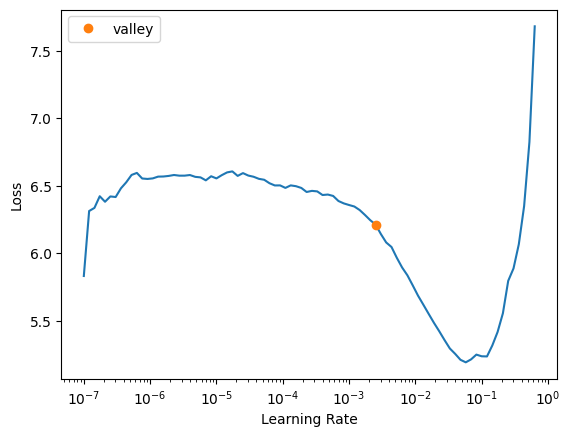

In [55]:
learn_1.lr_find()

In [56]:
learn_1.fit_one_cycle(8, lr_max =3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.764303,1.162294,0.280868,00:22
1,1.238230,0.624373,0.187924,00:22
2,0.783361,0.433785,0.120081,00:21
3,0.560491,0.358054,0.094980,00:21
4,0.401948,0.296631,0.089552,00:21
5,0.265502,0.275304,0.084803,00:21
6,0.208793,0.252811,0.069878,00:21
7,0.166373,0.248260,0.073948,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.258427,0.287237,0.081411,00:21


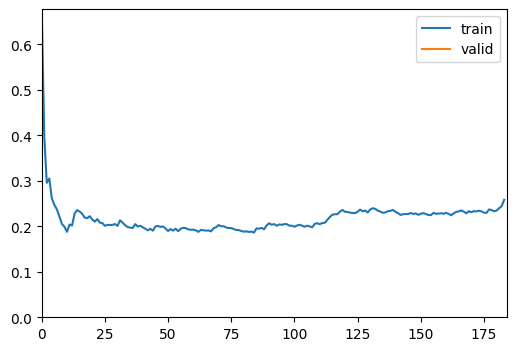

epoch,train_loss,valid_loss,error_rate,time
0,0.209939,0.187862,0.052239,00:24
1,0.258268,0.248111,0.071913,00:23
2,0.153608,0.187146,0.054953,00:23
3,0.137066,0.155406,0.043419,00:23
4,0.088907,0.138923,0.037313,00:23
5,0.062428,0.125874,0.033921,00:23


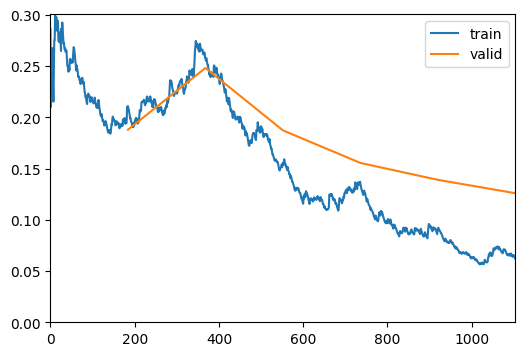

In [57]:
#tuning hyperparameters
learn_1.fine_tune(6, 3e-3, cbs=ShowGraphCallback())

In [58]:
learn_1.summary()

Sequential (Input shape: 32 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 64 x 64   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 32 x 32   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 32 x 32  
Conv2d                                    16384      True      
BatchNorm2d                        

In [59]:
results(learn_1)

Model's overall accuracy: 96.6%
The accuracy change over the baseline model is 0.7%
Model's validation loss: 12.6%
The validation change over the baseline model is -4.1%


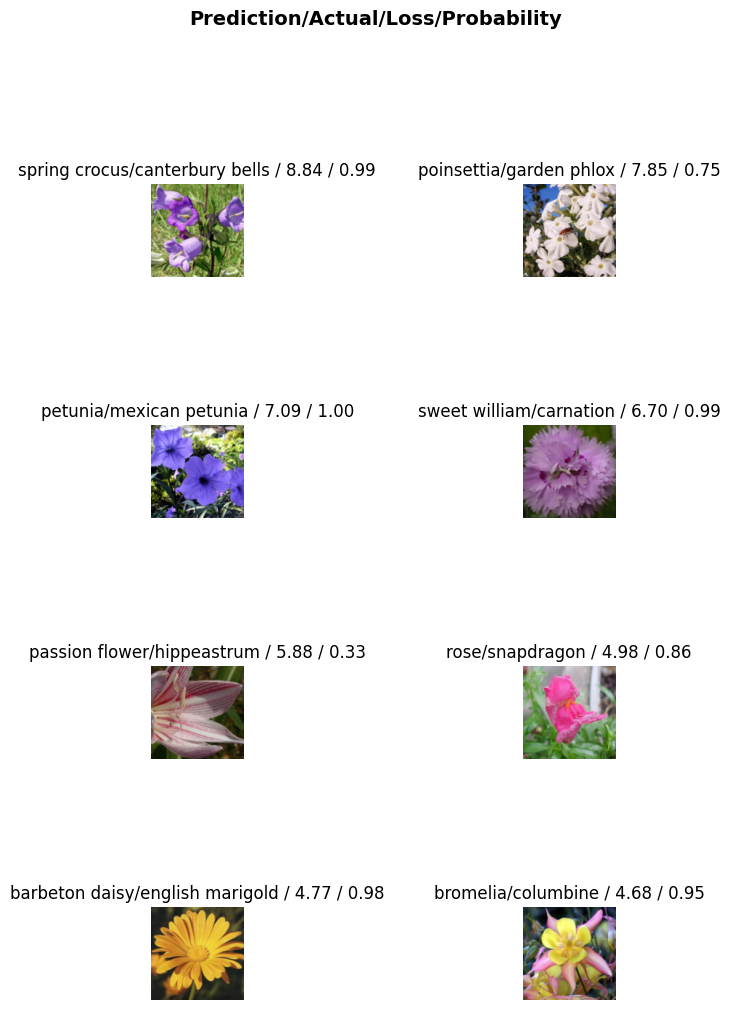

[('english marigold', 'barbeton daisy', 2),
 ('azalea', 'clematis', 1),
 ('azalea', 'petunia', 1),
 ('bearded iris', 'canna lily', 1),
 ('bee balm', 'purple coneflower', 1),
 ('bolero deep blue', 'cyclamen', 1),
 ('bolero deep blue', 'ruby-lipped cattleya', 1),
 ('canna lily', 'hippeastrum', 1),
 ('canna lily', 'yellow iris', 1),
 ('canterbury bells', 'clematis', 1),
 ('canterbury bells', 'pelargonium', 1),
 ('canterbury bells', 'spring crocus', 1),
 ('canterbury bells', 'sweet pea', 1),
 ('canterbury bells', 'thorn apple', 1),
 ('cape flower', 'bee balm', 1),
 ('carnation', 'azalea', 1),
 ('carnation', 'sweet william', 1),
 ('clematis', 'magnolia', 1),
 ('columbine', 'bromelia', 1),
 ('columbine', 'clematis', 1),
 ('columbine', 'peruvian lily', 1),
 ('corn poppy', 'watercress', 1),
 ('garden phlox', 'poinsettia', 1),
 ('garden phlox', 'sweet pea', 1),
 ('gaura', 'cape flower', 1),
 ('hippeastrum', 'passion flower', 1),
 ('japanese anemone', 'clematis', 1),
 ('japanese anemone', 'hibis

In [61]:
#observing some erroneous predictions
interp = ClassificationInterpretation.from_learner(learn_1)
interp.plot_top_losses(k=8, nrows=4)
plt.subplots_adjust(wspace=3)
plt.show()
interp.most_confused()

#### Trying another model with two different augmentation parameters that include mode set to 'nearest' and pad_mode set to 'zeros'.

In [62]:
#transformations list
transforms_2 = aug_transforms(
        mult = 1.0,
        do_flip = True,
        flip_vert = False,
        max_rotate = 10.0,
        min_zoom = 1.0,
        max_zoom = 1.1,
        max_lighting = 0.2,
        max_warp = 0.2,
        p_affine = 0.75,
        p_lighting = 0.75,
        xtra_tfms = None,
        size = None,
        mode= 'nearest', #changed from 'bilinear'
        pad_mode='zeros', #changed from 'reflection'
        align_corners=True,
        batch=False,
        min_scale=1.0)

In [63]:
#Create ImageDataLoader
dl_2 = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(128),
       batch_tfms=[*transforms_2, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [64]:
#create model
learn_2 = vision_learner(dl_2, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0012022644514217973)

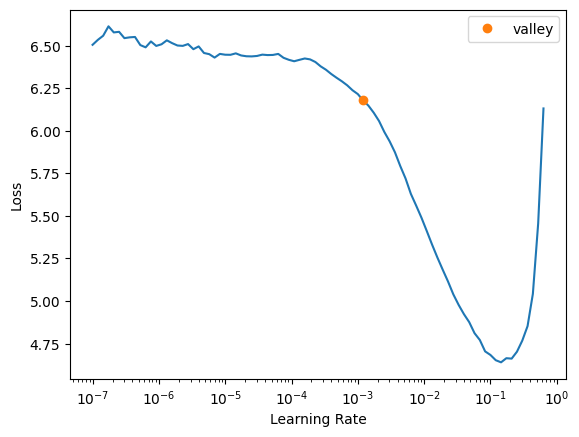

In [65]:
learn_2.lr_find()

In [66]:
learn_2.fit_one_cycle(7, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.359505,1.280683,0.314111,00:19
1,1.495269,0.641381,0.176391,00:19
2,0.821842,0.470153,0.125509,00:19
3,0.519470,0.323464,0.089552,00:19
4,0.343191,0.289553,0.084803,00:19
5,0.255333,0.275103,0.078019,00:19
6,0.209161,0.263552,0.074627,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.291720,0.365483,0.114654,00:19


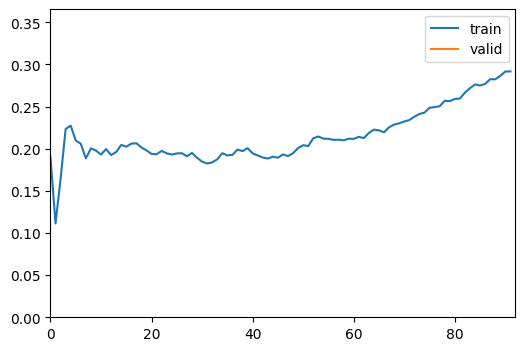

epoch,train_loss,valid_loss,error_rate,time
0,0.232492,0.263256,0.072592,00:19
1,0.177308,0.235496,0.069199,00:19
2,0.136458,0.202855,0.058345,00:19
3,0.106402,0.179123,0.054953,00:19
4,0.073196,0.175283,0.048168,00:19
5,0.052955,0.164591,0.048168,00:19


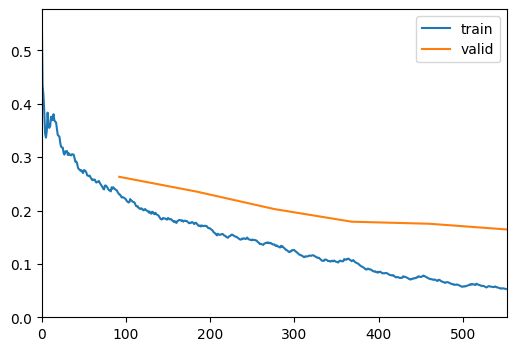

In [67]:
#tuning hyperparameters
learn_2.fine_tune(6, 3e-3, cbs=ShowGraphCallback())

In [68]:
learn_2.summary()

Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 64 x 64   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 32 x 32   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 32 x 32  
Conv2d                                    16384      True      
BatchNorm2d                        

In [69]:
results(learn_2)

Model's overall accuracy: 95.2%
The accuracy change over the baseline model is -0.7%
Model's validation loss: 16.5%
The validation change over the baseline model is -0.2%


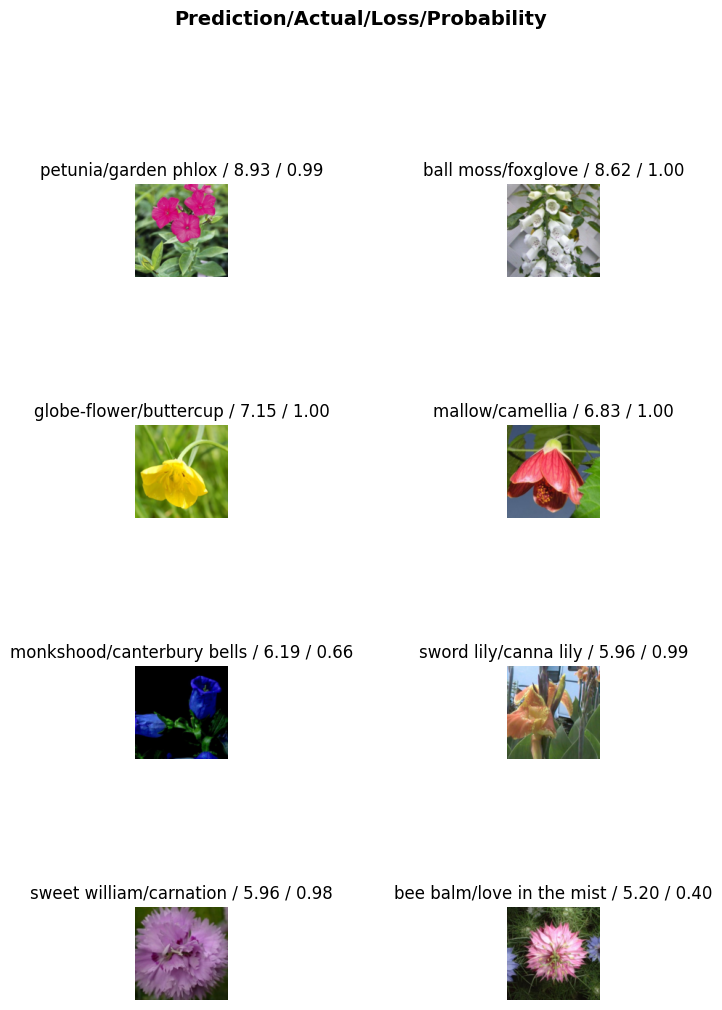

[('azalea', 'carnation', 2),
 ('garden phlox', 'petunia', 2),
 ('hibiscus', 'mallow', 2),
 ('azalea', 'bougainvillea', 1),
 ('azalea', 'camellia', 1),
 ('azalea', 'canna lily', 1),
 ('balloon flower', 'canterbury bells', 1),
 ('balloon flower', 'magnolia', 1),
 ('bearded iris', 'canna lily', 1),
 ('bee balm', 'love in the mist', 1),
 ('buttercup', 'globe-flower', 1),
 ('camellia', 'mallow', 1),
 ('camellia', 'water lily', 1),
 ('canna lily', 'bougainvillea', 1),
 ('canna lily', 'sword lily', 1),
 ('canterbury bells', 'mexican petunia', 1),
 ('canterbury bells', 'monkshood', 1),
 ('canterbury bells', 'ruby-lipped cattleya', 1),
 ('canterbury bells', 'sweet pea', 1),
 ('cape flower', 'magnolia', 1),
 ('carnation', 'sweet william', 1),
 ('clematis', 'primula', 1),
 ('columbine', 'cape flower', 1),
 ('columbine', 'magnolia', 1),
 ('columbine', 'ruby-lipped cattleya', 1),
 ('columbine', 'windflower', 1),
 ('corn poppy', 'rose', 1),
 ('cyclamen', 'sweet pea', 1),
 ('foxglove', 'ball moss', 1

In [70]:
#observing some erroneous predictions
interp = ClassificationInterpretation.from_learner(learn_2)
interp.plot_top_losses(k=8, nrows=4)
plt.subplots_adjust(wspace=3)
plt.show()
interp.most_confused()

#### Worse accuracy and tiny bit better validation loss baseline is disappointing.  I will revert to using aug_transforms of learn_1 with the following model trials.  
#### Now I want to explore a new model with larger images (224 pixels).

In [71]:
#transformations list
transforms_3 = aug_transforms(
        mult = 1.0,
        do_flip = True,
        flip_vert = False,
        max_rotate = 10.0,
        min_zoom = 1.0,
        max_zoom = 1.1,
        max_lighting = 0.2,
        max_warp = 0.2,
        p_affine = 0.75,
        p_lighting = 0.75,
        xtra_tfms = None,
        size = None,
        mode= 'bilinear',
        pad_mode='reflection',
        align_corners=True,
        batch=False,
        min_scale=1.0)

In [72]:
#Create ImageDataLoader
dl_3 = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(224),
       batch_tfms=[*transforms_3, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [73]:
#create model
learn_3 = vision_learner(dl_3, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0014454397605732083)

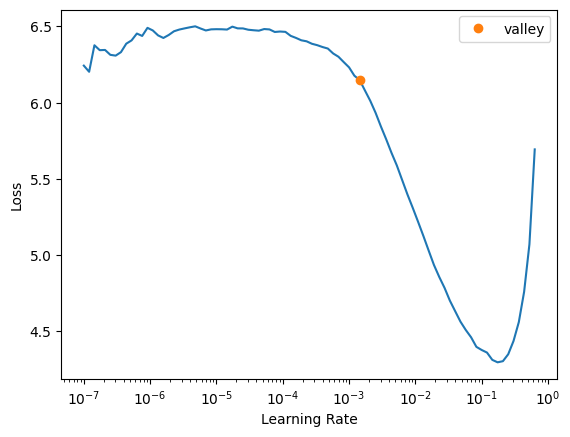

In [74]:
learn_3.lr_find()

In [75]:
learn_3.fit_one_cycle(8, lr_max = 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.932239,0.849628,0.209634,00:21
1,1.012704,0.302067,0.081411,00:21
2,0.438905,0.241547,0.068521,00:20
3,0.219352,0.182579,0.049525,00:20
4,0.137936,0.161154,0.040706,00:20
5,0.091962,0.141467,0.037992,00:20
6,0.060415,0.132214,0.027815,00:21
7,0.047448,0.130116,0.031886,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.087563,0.146871,0.035278,00:20


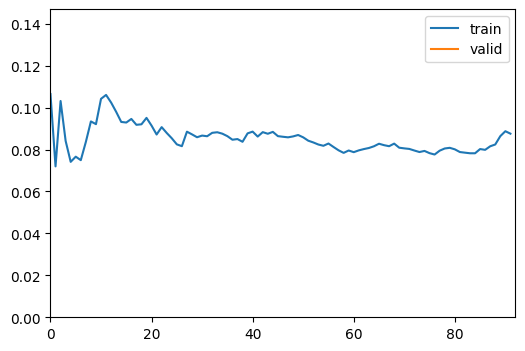

epoch,train_loss,valid_loss,error_rate,time
0,0.063501,0.115397,0.027137,00:20
1,0.047131,0.105306,0.027137,00:20
2,0.059661,0.116903,0.026459,00:20
3,0.038790,0.096061,0.022388,00:20
4,0.025427,0.087209,0.021031,00:20
5,0.015704,0.086972,0.019674,00:20


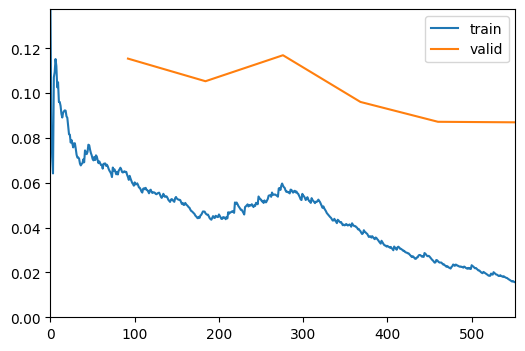

In [77]:
#tuning hyperparameters
learn_3.fine_tune(6, 3e-3, cbs=ShowGraphCallback())

In [78]:
learn_3.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

In [79]:
results(learn_3)

Model's overall accuracy: 98.0%
The accuracy change over the baseline model is 2.1%
Model's validation loss: 8.7%
The validation change over the baseline model is -8.0%


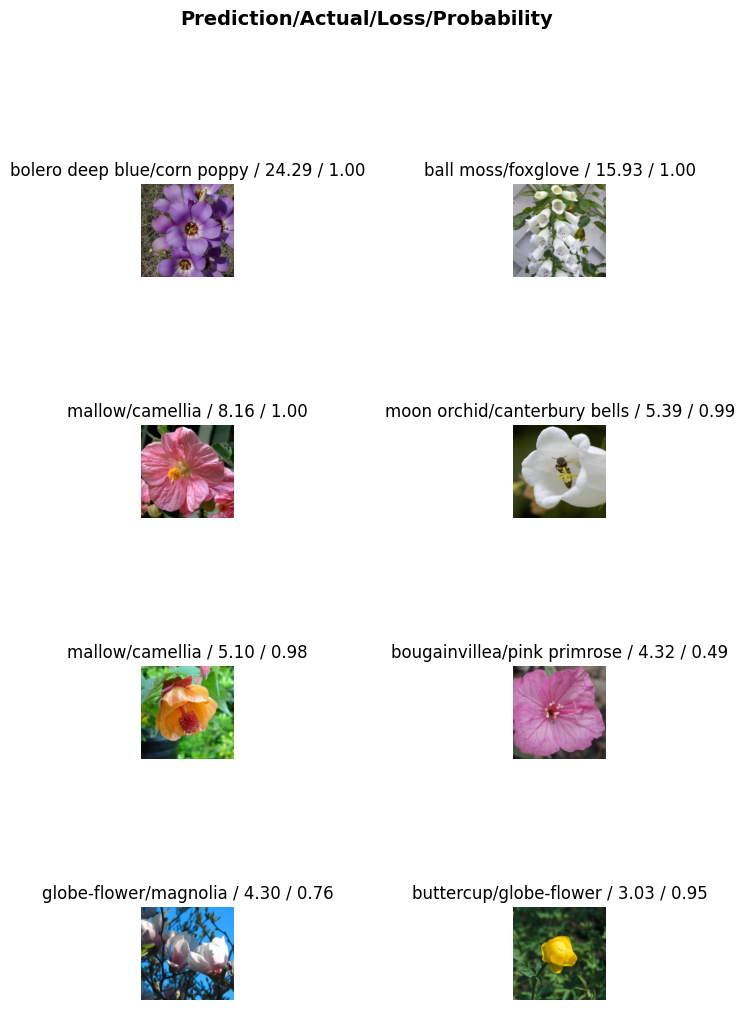

[('camellia', 'mallow', 2),
 ('azalea', 'camellia', 1),
 ('azalea', 'hippeastrum', 1),
 ('balloon flower', 'thorn apple', 1),
 ('bearded iris', 'thorn apple', 1),
 ('canna lily', 'camellia', 1),
 ('canterbury bells', 'moon orchid', 1),
 ('canterbury bells', 'stemless gentian', 1),
 ('carnation', 'sweet william', 1),
 ('common dandelion', "colt's foot", 1),
 ('corn poppy', 'bolero deep blue', 1),
 ('foxglove', 'ball moss', 1),
 ('foxglove', 'snapdragon', 1),
 ('globe-flower', 'buttercup', 1),
 ('magnolia', 'globe-flower', 1),
 ('mallow', 'hibiscus', 1),
 ('mexican petunia', 'petunia', 1),
 ('petunia', 'morning glory', 1),
 ('petunia', 'rose', 1),
 ('pink primrose', 'bougainvillea', 1),
 ('primula', 'cyclamen', 1),
 ('siam tulip', 'bromelia', 1),
 ('siam tulip', 'sweet pea', 1),
 ('spring crocus', 'camellia', 1),
 ('sweet pea', 'morning glory', 1),
 ('sword lily', 'bromelia', 1),
 ('sword lily', 'rose', 1),
 ('yellow iris', 'daffodil', 1)]

In [81]:
interp = ClassificationInterpretation.from_learner(learn_3)
interp.plot_top_losses(k=8, nrows=4)
plt.subplots_adjust(wspace=3)
plt.show()
interp.most_confused()

#### Next model trial will use max_rotate set to 15, and max_lighting increased to 0.3 with 224 pixel resized images.

In [82]:
#transformations list
transforms_4 = aug_transforms(
        mult = 1.0,
        do_flip = True,
        flip_vert = False,
        max_rotate = 15.0,
        min_zoom = 1.0,
        max_zoom = 1.2,
        max_lighting = 0.3,
        max_warp = 0.2,
        p_affine = 0.75,
        p_lighting = 0.75,
        xtra_tfms = None,
        size = None,
        mode= 'bilinear',
        pad_mode='reflection',
        align_corners=True,
        batch=False,
        min_scale=1.0)

In [83]:
#Create ImageDataLoader
dl_4 = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=train_images,
       labels=train_label_list,
       valid_pct=0.2,
       item_tfms=Resize(224),
       batch_tfms=[*transforms_4, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [84]:
learn_4 = vision_learner(dl_4, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0012022644514217973)

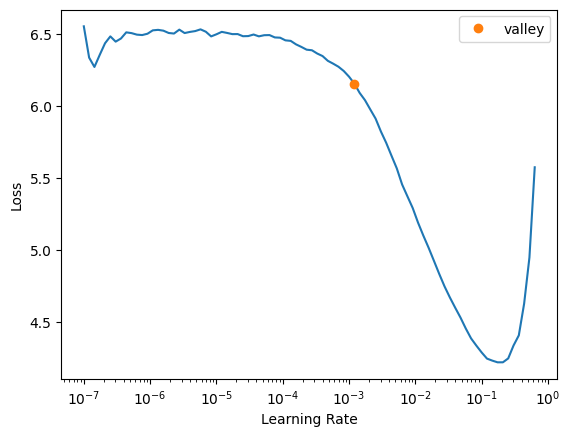

In [85]:
learn_4.lr_find()

In [86]:
learn_4.fit_one_cycle(7, lr_max = 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.749719,0.666194,0.170963,00:20
1,0.946861,0.307430,0.082768,00:20
2,0.432159,0.229065,0.061737,00:20
3,0.225816,0.171238,0.047490,00:20
4,0.152147,0.137415,0.037313,00:20
5,0.096971,0.127019,0.037992,00:20
6,0.075007,0.130391,0.040027,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.142805,0.203768,0.061058,00:20


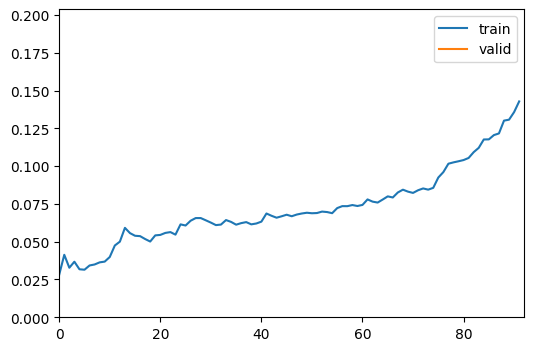

epoch,train_loss,valid_loss,error_rate,time
0,0.109022,0.125996,0.035278,00:20
1,0.084827,0.113922,0.029851,00:20
2,0.071742,0.103740,0.029172,00:20
3,0.042154,0.096610,0.029172,00:20
4,0.033935,0.082221,0.018318,00:20
5,0.022970,0.079421,0.021031,00:20


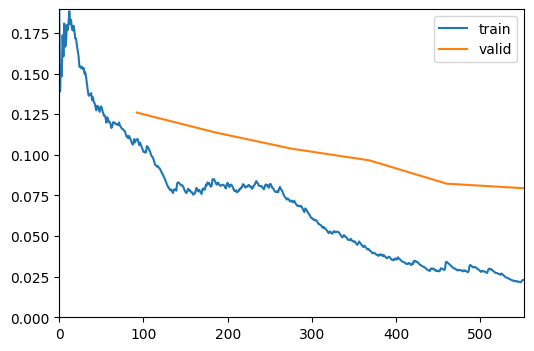

In [87]:
#tuning hyperparameters
learn_4.fine_tune(6, 3e-3, cbs=ShowGraphCallback())

In [88]:
learn_4.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

In [89]:
results(learn_4)

Model's overall accuracy: 97.9%
The accuracy change over the baseline model is 2.0%
Model's validation loss: 7.9%
The validation change over the baseline model is -8.8%


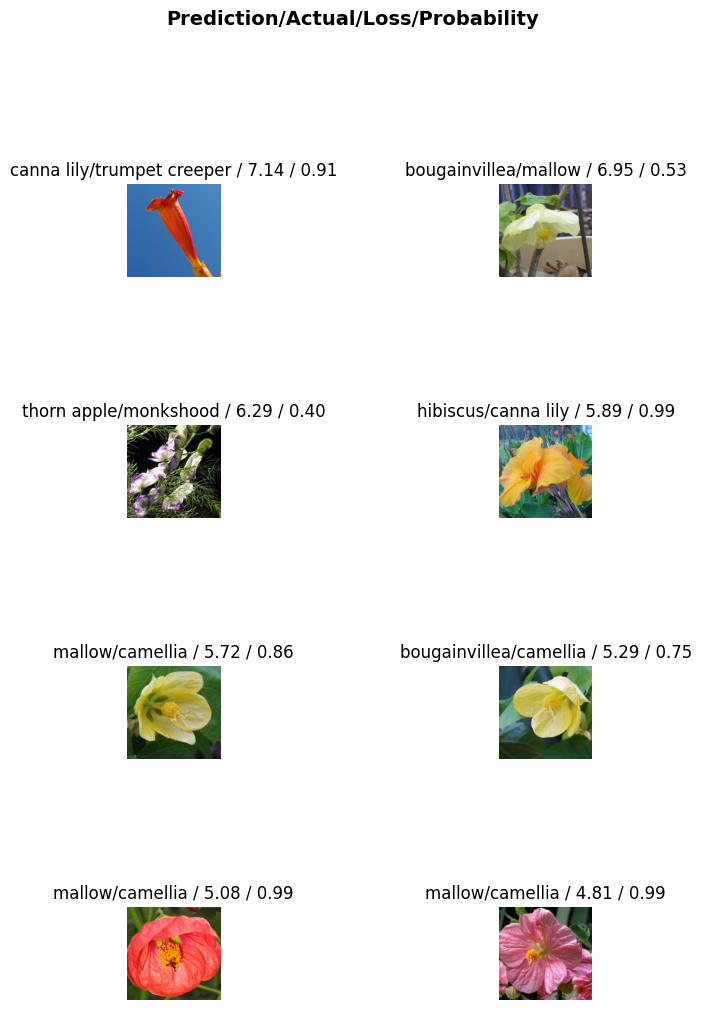

In [90]:
interp = ClassificationInterpretation.from_learner(learn_4)
interp.plot_top_losses(k=8, nrows=4)
plt.subplots_adjust(wspace=3)
plt.show()

#### Learn_4 has improved validity loss, and basically the same error rate.  Testing the best model (learn_4) for real-world prediction accuracy.

In [91]:
#Creating ImageDataLoader from learn_4's dataloader object on test_items and test_label_list
dls = ImageDataLoaders.from_lists(
       "/Users/maxwellkreitman/Desktop/CV_flower_project/pics",
       fnames=test_images,
       labels=test_label_list,
       valid_pct=0.2,
       item_tfms=Resize(224),
       batch_tfms=[*transforms_4, Normalize.from_stats(*imagenet_stats)],
       class_weights=class_weights)

In [92]:
#Creating the test images ImageDataLoader from learn_3's
#dataloader dl_3 on test_items image collection and
#getting calculating predictions.
test_dl = dl_4.test_dl(test_images)

# Calculating predictions and validation data.
preds, _ = learn_4.get_preds(dl=test_dl)

In [93]:
#I need to convert my label list to a tensor,
#but there is an intermediate string label -> numerical label step.
#Encoding labels:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(test_label_list)
test_labels_tensor = tensor(encoded_labels)

In [94]:
#accuracy calculation
acc = accuracy(preds, test_labels_tensor)
accuracy_percentage_test = acc.item()

In [95]:
print(f"Model image_4 prediction accuracy on test_images: {accuracy_percentage_test:.2%}")

Model image_4 prediction accuracy on test_images: 98.78%


In [99]:
def save_results_to_file(model):
    validation, accuracy = model.validate()
    accuracy_percentage = (1 - accuracy) * 100
    validation_percentage = validation * 100

    difference_accuracy = accuracy_percentage - accuracy_percentage_cv
    difference_validation = validation_percentage - validation_percentage_cv

    # Create a string with the results
    output_content = f"Model's overall accuracy: {accuracy_percentage:.1f}%\n" \
                     f"The accuracy change over the baseline model is {difference_accuracy:.1f}%\n" \
                     f"Model's validation loss: {validation_percentage:.1f}%\n" \
                     f"The validation change over the baseline model is {difference_validation:.1f}%\n"\
                     f"Test set accuracy: {accuracy_percentage_test:.2%}"

    # Get today's date
    today_date = datetime.date.today().strftime("%d_%m_%y")

    directory_path = "/content/drive/MyDrive/Fellowship.ai"

    # Create the file name
    file_name = os.path.join(directory_path, f"best_model_results_{today_date}.txt")

    # Write content to the file
    with open(file_name, 'w') as file:
        file.write(output_content)

    print(f"Results saved in file '{file_name}'.")

In [100]:
save_results_to_file(learn_4)

Results saved in file '/content/drive/MyDrive/Fellowship.ai/best_model_results_28_01_24.txt'.


In [101]:
learn_4.save('/content/drive/MyDrive/Fellowship.ai/models')

Path('/content/drive/MyDrive/Fellowship.ai/models.pth')